In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
import matplotlib.patches as mpatches
import numpy as np
import re
import requests
import folium
import seaborn as sns

In [ ]:
# Cargar archivo csv
dataset = pd.read_csv("SCRAPER.csv")

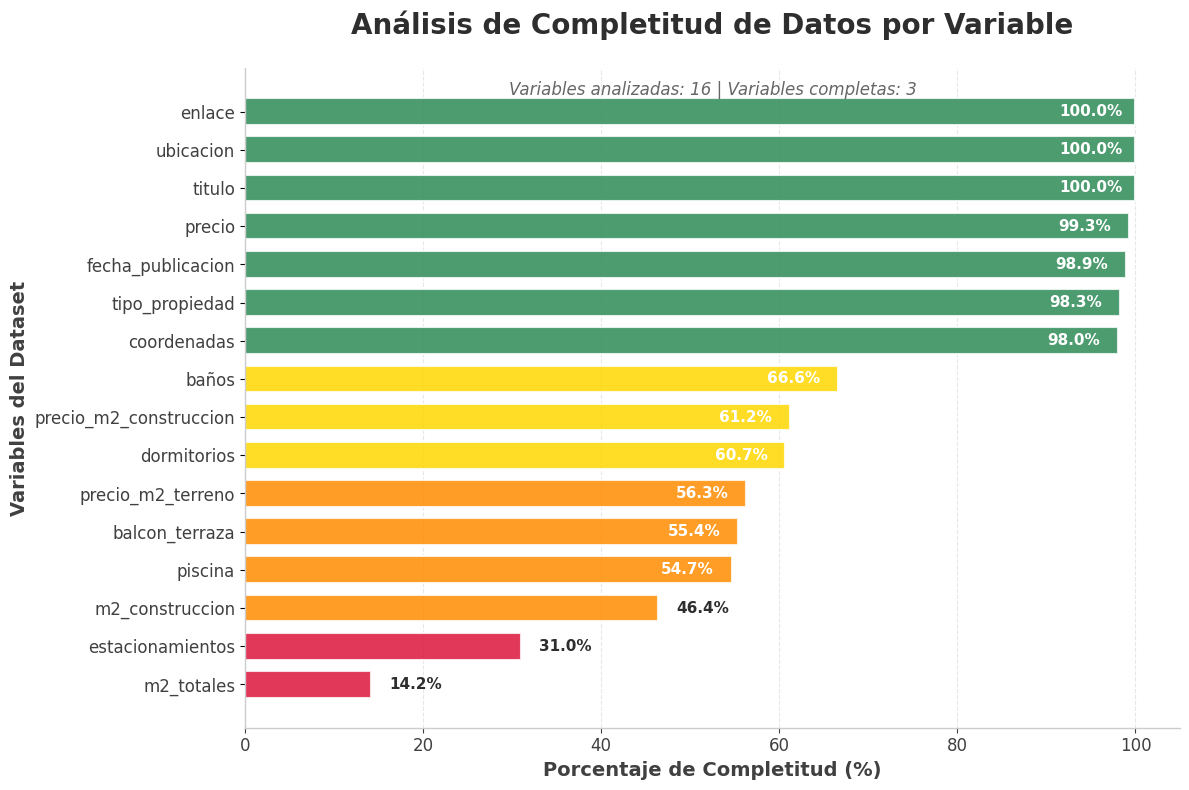

In [ ]:
# Calcular porcentaje de datos no nulos por variable
Porcentaje_datos = round(dataset.count() / dataset.shape[0] * 100, 1).sort_values(ascending=True)

# Configurar
plt.style.use('default')

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Crear colores basados en el porcentaje de completitud
def get_color_by_completeness(percentage):
    if percentage >= 80:
        return '#2E8B57'
    elif percentage >= 60:
        return '#FFD700'
    elif percentage >= 40:
        return '#FF8C00'
    else:
        return '#DC143C'

# Aplicar colores según completitud
colors = [get_color_by_completeness(p) for p in Porcentaje_datos.values]

# Crear barras horizontales con estilo moderno
bars = ax.barh(
    range(len(Porcentaje_datos)), 
    Porcentaje_datos.values,
    color=colors,
    alpha=0.85,
    height=0.7,
    edgecolor='white',
    linewidth=1.5
)

# Agregar efectos visuales a las barras
for bar in bars:
    bar.set_capstyle('round')

# Agregar valores con posicionamiento
for i, (var, percentage) in enumerate(Porcentaje_datos.items()):
    # Determinar posición del texto
    if percentage > 50:
        # Texto dentro de la barra
        x_pos = percentage - 5
        color = 'white'
        weight = 'bold'
    else:
        # Texto fuera de la barra
        x_pos = percentage + 2
        color = '#2E2E2E'
        weight = '600'
    
    ax.text(x_pos, i, f'{percentage}%', 
           va='center', ha='center' if percentage > 50 else 'left',
           fontweight=weight, 
           fontsize=11,
           color=color)

# Configurar etiquetas del eje Y
ax.set_yticks(range(len(Porcentaje_datos)))
ax.set_yticklabels(Porcentaje_datos.index, fontsize=12, color='#404040')

# Título
ax.set_title('Análisis de Completitud de Datos por Variable', 
            fontsize=20, 
            fontweight='bold', 
            pad=25,
            color='#2E2E2E')

# Subtítulo
total_vars = len(Porcentaje_datos)
complete_vars = sum(1 for p in Porcentaje_datos if p == 100)
ax.text(0.5, 0.98, f'Variables analizadas: {total_vars} | Variables completas: {complete_vars}', 
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=12,
        style='italic',
        color='#666666')

# Etiquetas de ejes
ax.set_xlabel('Porcentaje de Completitud (%)', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

ax.set_ylabel('Variables del Dataset', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

# Configurar eje
ax.set_xlim(0, 105)
ax.set_xticks(range(0, 101, 20))
ax.tick_params(axis='x', labelsize=12, colors='#404040')

# Grid
ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Personalizar spines
for spine in ax.spines.values():
    spine.set_color('#CCCCCC')
    spine.set_linewidth(1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Layout ajustado
plt.tight_layout()

plt.show()


In [4]:
# Quitar filas sin precio
dataset = dataset[dataset['precio'].notnull()]

In [5]:
# Agregar columna con diferenciación entre UF y $
if dataset['precio'].str.contains('UF').any():
    dataset['moneda'] = dataset['precio'].apply(lambda x: 'UF' if 'UF' in x else '$')

# Transformar precio a valor numérico
def extraer_precio(texto):
    """Extraer precio de una propiedad"""
    patrones_precio = [
        r'\$\s*\d{1,3}(?:\.\d{3})*(?:,\d+)?',
        r'\d{1,3}(?:\.\d{3})*(?:,\d+)?\s*UF',
        r'UF\s*\d{1,3}(?:\.\d{3})*(?:,\d+)?',
        r'\d{1,3}(?:\.\d{3})*(?:,\d+)?\s*CLP',
        r'CLP\s*\d{1,3}(?:\.\d{3})*(?:,\d+)?'
    ]
    
    for patron in patrones_precio:
        match = re.search(patron, texto, re.IGNORECASE)
        if match:
            precio = match.group().strip()
            # Normalizar espacios
            precio = re.sub(r'\s+', ' ', precio)
            return precio
    
    return None

def precio_a_float(precio_str):
    """Convierte un precio extraído a float"""
    if precio_str is None:
        return None
    
    # Eliminar símbolos de $ y UF/CLP
    limpio = re.sub(r'[^\d,.-]', '', precio_str)

    # Quitar puntos de miles y cambiar coma por punto
    limpio = limpio.replace(".", "").replace(",", ".")
    
    try:
        return float(limpio)
    except ValueError:
        return None

dataset['precio_valor'] = dataset['precio'].apply(extraer_precio)
dataset['precio_valor'] = dataset['precio'].apply(precio_a_float)

In [ ]:
#API Key
api_key = "########" # N° de API Key (Privado)

# Endpoint CMF para obtener UF en formato JSON
url = "https://api.cmfchile.cl/api-sbifv3/recursos_api/uf"
params = {
    "apikey": api_key,
    "formato": "json"
}

# Hacemos la consulta
response = requests.get(url, params=params)
response.raise_for_status()

# Convertimos la respuesta en JSON
data = response.json()

# Extraemos el valor de la UF
uf_entry = data.get("UFs", [None])[0]

if uf_entry and "Valor" in uf_entry:
    uf_valor_str = uf_entry["Valor"]
    fecha = uf_entry.get("Fecha", "Desconocida")
    
    # Convertimos de string a float
    uf_valor_float = float(uf_valor_str.replace(".", "").replace(",", "."))
    
    print(f"Valor UF del {fecha}: {uf_valor_float}")
else:
    print("No se encontró el valor de la UF para la consulta.")

Valor UF del 2025-09-10: 39485.65


In [7]:
# Columna valor en pesos 
dataset['valor_en_pesos'] = np.where(
    dataset['moneda'].str.contains("UF", case=False, na=False),
    round(dataset['precio_valor'] * uf_valor_float,0),
    dataset['precio_valor']
)

# Columna valor en UF
dataset['valor_en_uf'] = np.where(
    dataset['moneda'].str.contains("\$", case=False, na=False),
    round(dataset['precio_valor'] / uf_valor_float, 2),
    dataset['precio_valor']
)

In [8]:
dataset

,titulo,precio,ubicacion,dormitorios,baños,estacionamientos,m2_construccion,m2_totales,tipo_propiedad,piscina,balcon_terraza,coordenadas,enlace,fecha_publicacion,precio_m2_construccion,precio_m2_terreno,moneda,precio_valor,valor_en_pesos,valor_en_uf
0,Inmobiliaria GPR Puerto Montt Condominio Bosqu...,"UF2.632,00",Puerto Montt,2.0,2.0,NaN,52.0,NaN,NaN,NaN,NaN,"-41.454090875285310, -72.915591041342170",https://www.yapo.cl/bienes-raices-proyectos-nu...,NaN,NaN,NaN,UF,2632.0,1.039262e+08,2632.00
1,Inmobiliaria GPR Puerto Montt Condominio Hacie...,"UF3.929,00",Puerto Montt,3.0,3.0,NaN,72.0,NaN,NaN,NaN,NaN,"-41.453692838778850, -72.910875717893990",https://www.yapo.cl/bienes-raices-proyectos-nu...,NaN,NaN,NaN,UF,3929.0,1.551391e+08,3929.00
2,Inmobiliaria Aconcagua Puerto Montt Condominio...,"UF2.750,00",Puerto Montt,2.0,1.0,NaN,50.0,NaN,NaN,NaN,NaN,"-41.454396437006764, -72.907447854772950",https://www.yapo.cl/bienes-raices-proyectos-nu...,NaN,NaN,NaN,UF,2750.0,1.085855e+08,2750.00
3,Valentina Vallarino Sulzer Puerto Montt CASA C...,"UF2.850,00",Puerto Montt,3.0,2.0,NaN,130.0,NaN,casa,no,¡Pregunta al anunciante!,"-41.481654403390000, -72.986883364413000",https://www.yapo.cl/bienes-raices-venta-de-pro...,27/08/2025,"UF21,92",NaN,UF,2850.0,1.125341e+08,2850.00
4,TERRAGESTION Gestión Inmobiliaria Puerto Montt...,$370.000.000,Puerto Montt,3.0,3.0,2.0,140.0,NaN,departamento,no,¡Pregunta al anunciante!,"-41.472799855318630, -72.947648803488160",https://www.yapo.cl/bienes-raices-venta-de-pro...,07/08/2025,$2.642.857,NaN,$,370000000.0,3.700000e+08,9370.49
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,Cruz Balmaceda Propiedades - Constanza Osses P...,$45.000.000,Puerto Montt,NaN,NaN,NaN,NaN,NaN,parcela,NaN,NaN,"-41.459528000000000, -73.243210300000000",https://www.yapo.cl/bienes-raices-venta-de-pro...,18/09/2024,NaN,$8.973,$,45000000.0,4.500000e+07,1139.65
834,Cruz Balmaceda Propiedades - Francisco Puerto ...,"UF36.000,00",Puerto Montt,6.0,3.0,NaN,NaN,NaN,terreno,no,NaN,"-41.488388048297000, -72.894435587094000",https://www.yapo.cl/bienes-raices-venta-de-pro...,30/01/2025,NaN,"UF6,00",UF,36000.0,1.421483e+09,36000.00
835,ASESORIA Y GESTION SURPROP SPA Puerto Montt Op...,$189.900.000,Puerto Montt,4.0,4.0,1.0,136.0,NaN,terreno,no,¡Pregunta al anunciante!,"-41.481905400000000, -72.970384100000000",https://www.yapo.cl/bienes-raices-venta-de-pro...,19/06/2025,$1.396.323,$759.600,$,189900000.0,1.899000e+08,4809.34
836,María Ester Larrañaga Puerto Montt Casa excele...,"UF7.000,00",Puerto Montt,3.0,2.0,1.0,115.0,NaN,casa,no,¡Pregunta al anunciante!,"-41.477744400000000, -72.907001100000000",https://www.yapo.cl/bienes-raices-venta-de-pro...,13/07/2025,"UF60,86","UF20,00",UF,7000.0,2.763996e+08,7000.00


In [9]:
# Función para separar las coordenadas
def separar_coordenadas(coord_str):
    """
    Separa una cadena de coordenadas en latitud y longitud
    """
    if pd.isna(coord_str):
        return pd.Series([np.nan, np.nan])
    
    try:
        # Limpiar la cadena y dividir por la coma
        coords = str(coord_str).strip().split(',')
        if len(coords) == 2:
            lat = float(coords[0].strip())
            lon = float(coords[1].strip())
            return pd.Series([lat, lon])
        else:
            return pd.Series([np.nan, np.nan])
    except:
        return pd.Series([np.nan, np.nan])

# Aplicar la función para separar las coordenadas
dataset[['latitud', 'longitud']] = dataset['coordenadas'].apply(separar_coordenadas)

# Eliminar filas con valores NaN en las coordenadas
dataset_clean = dataset.dropna(subset=['latitud', 'longitud'])

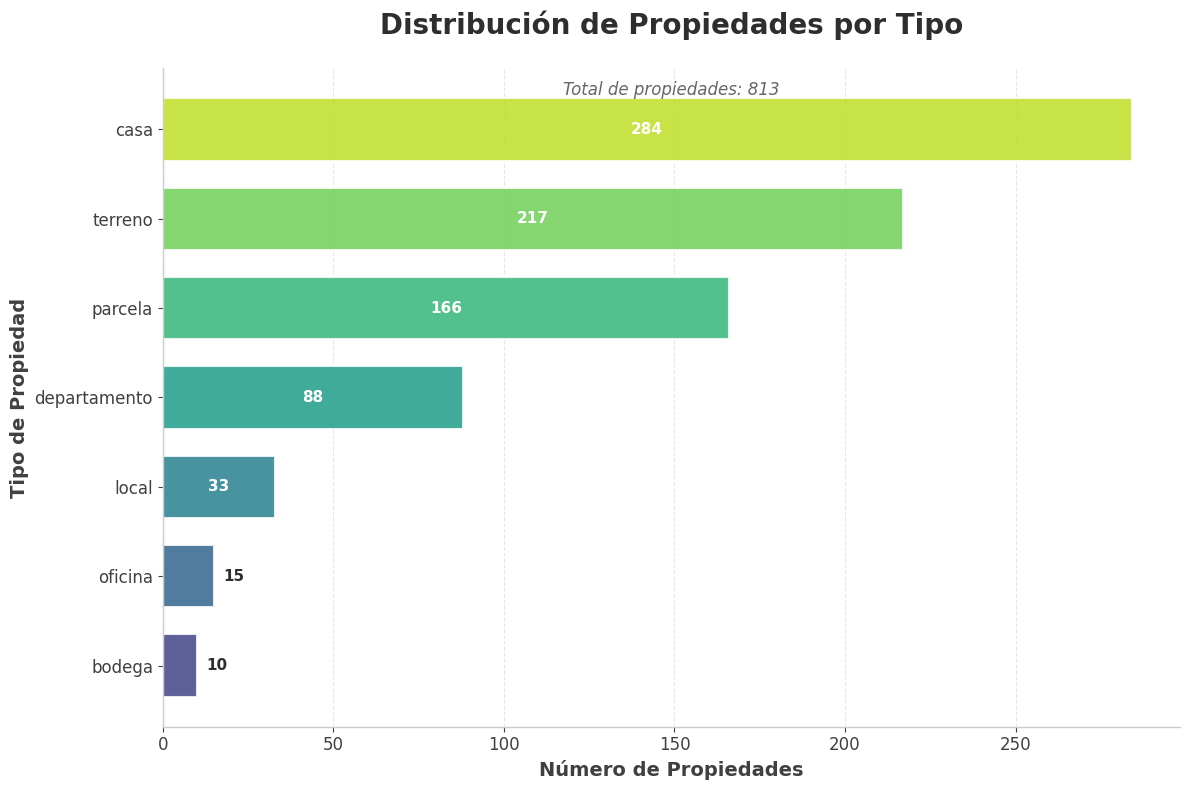

In [10]:
# Configurar estilo
plt.style.use('default')

# Obtener datos y ordenar
tipo_recuento = dataset_clean['tipo_propiedad'].value_counts().sort_values(ascending=True)

# Crear figura
fig, ax = plt.subplots(figsize=(12, 8))

# Crear paleta de colores degradada
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(tipo_recuento)))

# Crear barras horizontales
bars = ax.barh(
    tipo_recuento.index, 
    tipo_recuento.values,
    color=colors,
    alpha=0.85,
    height=0.7,
    edgecolor='white',
    linewidth=1.5
)

# Agregar gradiente
for i, bar in enumerate(bars):
    bar.set_capstyle('round')
    
# Agregar etiquetas de valor
for i, (index, value) in enumerate(tipo_recuento.items()):
    # Posicionar texto dentro o fuera según el largo de la barra
    max_val = tipo_recuento.max()
    if value > max_val * 0.1:  # Si la barra es lo suficientemente larga
        ax.text(value/2, i, f'{value:,}', 
               va='center', ha='center', 
               fontweight='bold', 
               fontsize=11,
               color='white')
    else:  # Para barras pequeñas
        ax.text(value + max_val*0.01, i, f'{value:,}', 
               va='center', ha='left', 
               fontweight='600', 
               fontsize=11,
               color='#2E2E2E')

# Título
ax.set_title('Distribución de Propiedades por Tipo', 
            fontsize=20, 
            fontweight='bold', 
            pad=25,
            color='#2E2E2E')

# Subtítulo
total_props = tipo_recuento.sum()
ax.text(0.5, 0.98, f'Total de propiedades: {total_props:,}', 
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=12,
        style='italic',
        color='#666666')

# Título de ejes
ax.set_xlabel('Número de Propiedades', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

ax.set_ylabel('Tipo de Propiedad', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

# Etiquetas del eje Y
ax.tick_params(axis='y', labelsize=12, colors='#404040')
ax.tick_params(axis='x', labelsize=12, colors='#404040')

# Grid
ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Personalizar spines
for spine in ax.spines.values():
    spine.set_color('#CCCCCC')
    spine.set_linewidth(1)

# Remover spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mejorar márgenes
ax.margins(x=0.05)

# Layout ajustado
plt.tight_layout()

plt.show()

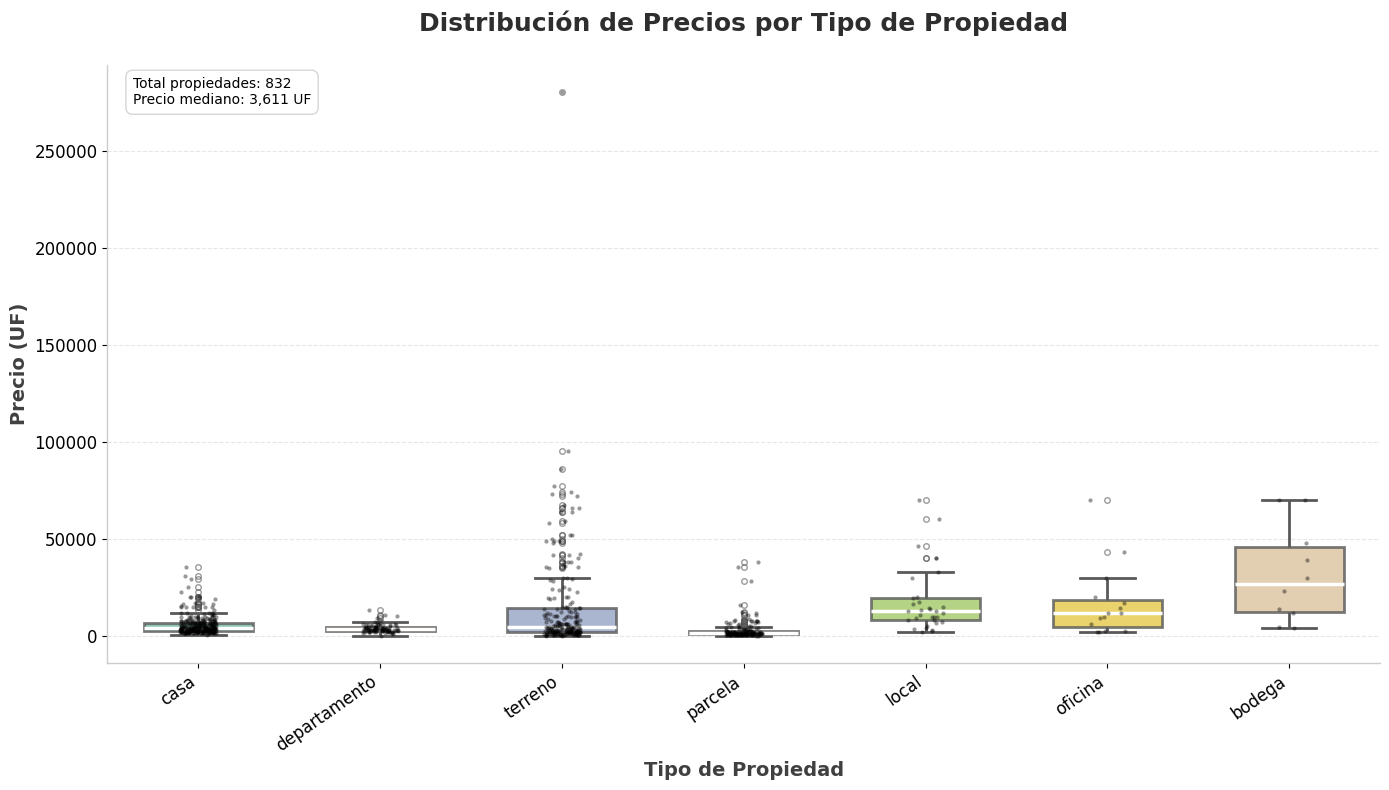

In [ ]:
# Configurar estilo moderno
plt.style.use('default')
sns.set_palette("husl")

# Crear figura con mejor proporción
fig, ax = plt.subplots(figsize=(14, 8))

# Boxplot con estilo moderno (corrigiendo deprecación)
box_plot = sns.boxplot(
    data=dataset, 
    x='tipo_propiedad', 
    y='valor_en_uf',
    hue='tipo_propiedad',  # Asignar hue para usar palette
    palette="Set2",
    legend=False,
    ax=ax,
    width=0.6,
    linewidth=2,
    fliersize=4,
    boxprops=dict(alpha=0.8),
    whiskerprops=dict(linewidth=2),
    capprops=dict(linewidth=2),
    medianprops=dict(color='white', linewidth=2.5),
    flierprops=dict(alpha=0.6)
)

# Agregar puntos individuales con jitter
sns.stripplot(
    data=dataset,
    x='tipo_propiedad',
    y='valor_en_uf',
    size=3,
    alpha=0.4,
    jitter=True,
    ax=ax,
    color='black'
)

# Personalizar título y etiquetas
ax.set_title('Distribución de Precios por Tipo de Propiedad', 
            fontsize=18, 
            fontweight='bold', 
            pad=25,
            color='#2E2E2E')

ax.set_xlabel('Tipo de Propiedad', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

ax.set_ylabel('Precio (UF)', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

# Rotar etiquetas del eje x
plt.setp(ax.get_xticklabels(), rotation=35, ha='right', fontsize=12)
ax.tick_params(axis='y', labelsize=12)

# grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8, axis='y')
ax.set_axisbelow(True)

# Personalizar spines
for spine in ax.spines.values():
    spine.set_color('#CCCCCC')
    spine.set_linewidth(1)

# Remover spine superior y derecho
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

# Agregar estadísticas
n_properties = len(dataset)
median_price = dataset['valor_en_uf'].median()
ax.text(0.02, 0.98, f'Total propiedades: {n_properties:,}\nPrecio mediano: {median_price:,.0f} UF', 
        transform=ax.transAxes, 
        fontsize=10,
        verticalalignment='top',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='#CCCCCC'))

# Mostrar el gráfico
plt.show()

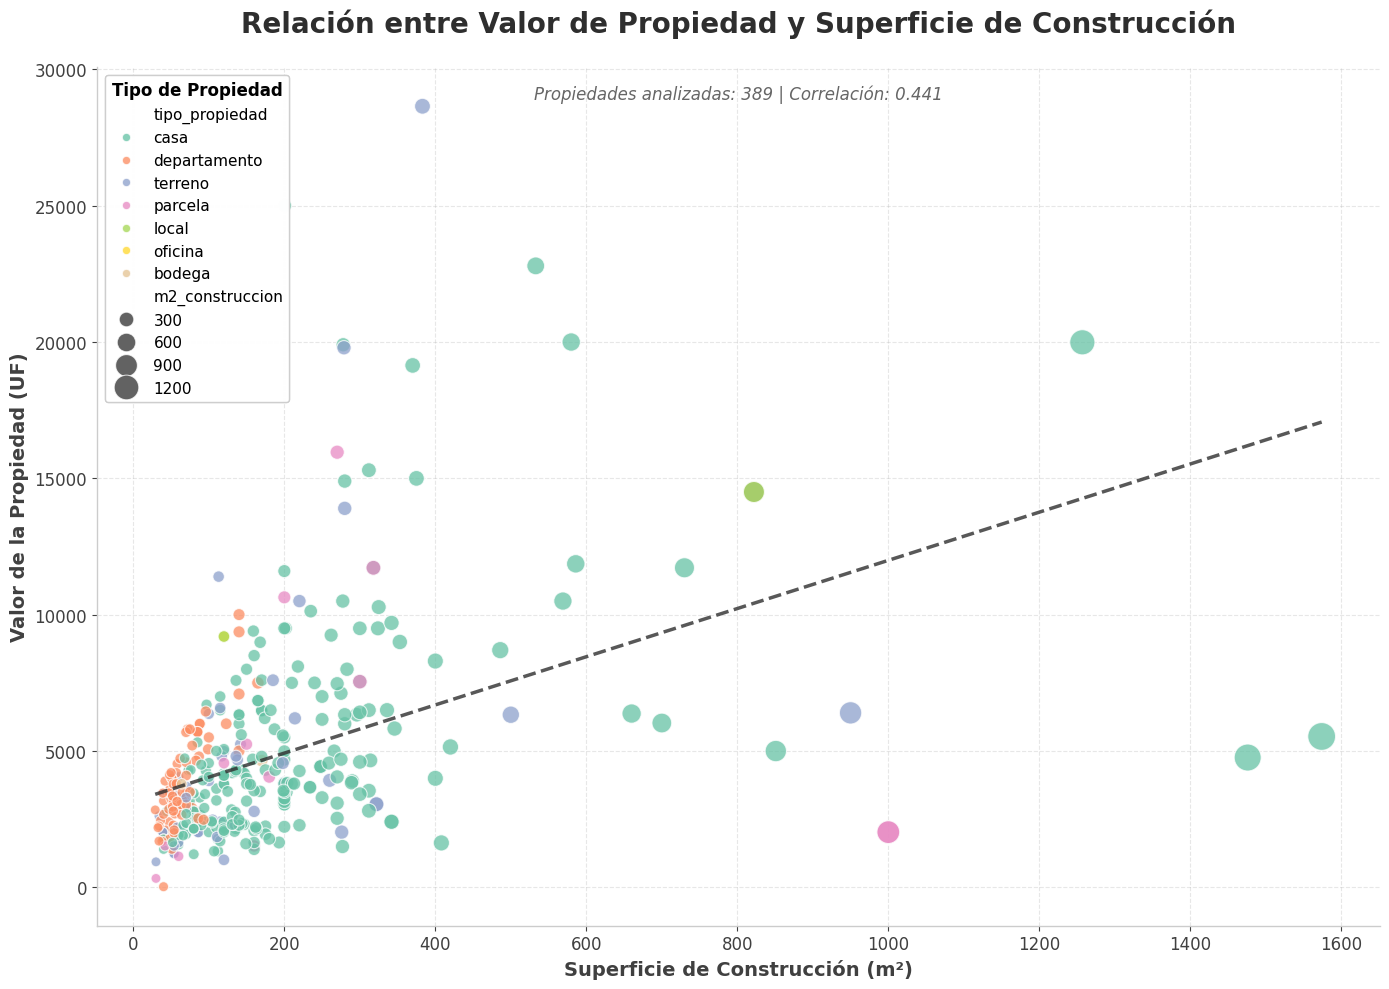

In [ ]:
# Configurar estilo
plt.style.use('default')
sns.set_palette("Set2")

# Crear figura con mejor proporción
fig, ax = plt.subplots(figsize=(14, 10))

# Gráfico de dispersión
scatter = sns.scatterplot(
    data=dataset, 
    x='m2_construccion', 
    y='valor_en_uf', 
    hue='tipo_propiedad',
    size='m2_construccion',
    sizes=(50, 400),
    alpha=0.75,
    palette='Set2',
    edgecolor='white',
    linewidth=0.8,
    ax=ax
)

# Agregar línea de tendencia general
from scipy import stats
from sklearn.linear_model import LinearRegression

# Filtrar valores válidos para la regresión
valid_mask = ~(dataset['m2_construccion'].isna() | dataset['valor_en_uf'].isna())
if valid_mask.sum() > 1:
    x_clean = dataset.loc[valid_mask, 'm2_construccion'].values.reshape(-1, 1)
    y_clean = dataset.loc[valid_mask, 'valor_en_uf'].values
    
    # Calcular regresión lineal
    reg = LinearRegression().fit(x_clean, y_clean)
    x_trend = np.linspace(dataset['m2_construccion'].min(), dataset['m2_construccion'].max(), 100)
    y_trend = reg.predict(x_trend.reshape(-1, 1))
    
    # Dibujar línea de tendencia
    ax.plot(x_trend, y_trend, 
           color='#2E2E2E', 
           linestyle='--', 
           linewidth=2.5, 
           alpha=0.8,
           label=f'Tendencia (R² = {reg.score(x_clean, y_clean):.3f})')

# Título
ax.set_title('Relación entre Valor de Propiedad y Superficie de Construcción', 
            fontsize=20, 
            fontweight='bold', 
            pad=25,
            color='#2E2E2E')

# Subtítulo
n_props = len(dataset.dropna(subset=['m2_construccion', 'valor_en_uf']))
correlation = dataset['m2_construccion'].corr(dataset['valor_en_uf'])
ax.text(0.5, 0.98, 
        f'Propiedades analizadas: {n_props:,} | Correlación: {correlation:.3f}', 
        transform=ax.transAxes,
        ha='center', va='top',
        fontsize=12,
        style='italic',
        color='#666666')

# Etiquetas de ejes
ax.set_xlabel('Superficie de Construcción (m²)', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

ax.set_ylabel('Valor de la Propiedad (UF)', 
             fontsize=14, 
             fontweight='600',
             color='#404040')

# Formato de ejes
ax.ticklabel_format(style='plain', axis='both')
ax.tick_params(axis='both', labelsize=12, colors='#404040')

# Grid
ax.grid(True, alpha=0.3, linestyle='--', linewidth=0.8)
ax.set_axisbelow(True)

# Personalizar spines
for spine in ax.spines.values():
    spine.set_color('#CCCCCC')
    spine.set_linewidth(1)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Mejorar la leyenda
handles, labels = ax.get_legend_handles_labels()

# Separar leyendas de tipo de propiedad y tamaño
hue_handles = handles[:-2] if len(handles) > 2 else handles[:-1]
hue_labels = labels[:-2] if len(labels) > 2 else labels[:-1]

# Crear leyenda principal
legend = ax.legend(hue_handles, hue_labels,
                   title='Tipo de Propiedad',
                   loc='upper left',
                   frameon=True,
                   fancybox=True,
                   fontsize=11,
                   title_fontsize=12)

# Configurar estilo de leyenda
legend.get_frame().set_facecolor('white')
legend.get_frame().set_alpha(0.9)
legend.get_frame().set_edgecolor('#CCCCCC')
legend.get_title().set_fontweight('bold')

# Volver a agregar la leyenda
ax.add_artist(legend)

plt.tight_layout()

plt.show()

In [35]:
# Calcular el centro del mapa
# -41.46947281365772, -72.94327080383917
center_lat = -41.46947281365772
center_lon = -72.94327080383917

# Crear el mapa base
mapa = folium.Map(
    location=[center_lat, center_lon], 
    zoom_start=13,
    tiles='OpenStreetMap'
)

# Agregar Font
font_awesome_css = """
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">
"""
mapa.get_root().html.add_child(folium.Element(font_awesome_css))

# Función para formatear la información del popup
def crear_popup_info(row):
    """Crea el contenido HTML para el popup"""
    
    # Formatear tipo de propiedad
    tipo = row['tipo_propiedad'].title() if pd.notna(row['tipo_propiedad']) else 'No especificado'


    # Formatear enlace
    # enlace = f"<a href='{row['enlace']}' target='_blank' style='color: #2E86AB;'>🔗 Ver más</a>" if pd.notna(row['enlace']) else 'No disponible'

    # Formatear valor en UF
    if pd.notna(row['valor_en_uf']):
        valor = f"{row['valor_en_uf']:,.2f} UF"
        # Convertir a pesos chilenos aproximados
        valor_clp = f"≈ ${row['valor_en_uf'] * uf_valor_float:,.0f} CLP"
    else:
        valor = "No especificado"
        valor_clp = ""
    
    # Formatear m2 de construcción
    m2_construccion = f"{row['m2_construccion']:,.0f} m²" if pd.notna(row['m2_construccion']) else 'No especificado'
    
    # Agregar m2 de terreno
    m2_terreno = ""
    if 'm2_terreno' in row.index and pd.notna(row['m2_terreno']):
        m2_terreno = f"<br><b>Terreno:</b> {row['m2_terreno']:,.0f} m²"
    
    # Formatear dormitorios
    dormitorios = f"{int(row['dormitorios'])} dormitorios" if 'dormitorios' in row.index and pd.notna(row['dormitorios']) else ''

    # Formatear baños
    baños = f"{int(row['baños'])} baños" if 'baños' in row.index and pd.notna(row['baños']) else ''
    
    # fecha de publicación
    fecha_pub = f"{row['fecha_publicacion']}" if 'fecha_publicacion' in row.index and pd.notna(row['fecha_publicacion']) else ''
    

    # Crear el HTML del popup
    popup_html = f"""
    <div style="font-family: Arial; font-size: 12px; width: 220px;">
        <h4 style="margin: 0 0 10px 0; color: #2E86AB; border-bottom: 1px solid #ddd;">
            <i class="fa {iconos_tipo.get(tipo.lower(), 'fa-question')}"></i> {tipo}
        </h4>
        <p style="margin: 5px 0;">
            <b>💰 Valor:</b> {valor}<br>
            <span style="color: #666;">{valor_clp}</span>
        </p>
        <p style="margin: 5px 0;">
            <b>📐 Construcción:</b> {m2_construccion}{m2_terreno}
        </p>
        <p style="margin: 5px 0;">
            <b>🛏️ Dormitorios:</b> {dormitorios}
        </p>
        <p style="margin: 5px 0;">
            <b>🛁 Baños:</b> {baños}
        </p>
        <p style="margin: 5px 0;">
            <b>📅 Fecha de Publicación:</b> {fecha_pub}
        </p>

    </div>
    """
    ''' Agregar enlace
        <p style="margin: 5px 0; font-size: 11px;">
            {enlace}
        </p>
    '''
    return popup_html

# Definir íconos según tipo de propiedad
iconos_tipo = {
    'casa': 'fa-home',
    'departamento': 'fa-building', 
    'parcela': 'fa-tree',
    'oficina': 'fa-briefcase',
    'local': 'fa-shopping-cart',
    'terreno': 'fa-map',
    'bodega': 'fa-archive',
    'otro': 'fa-question'
}

# Función para determinar color
def obtener_color_por_valor(valor):
    """Determina el color según el valor de la propiedad con rangos fijos"""
    if pd.isna(valor):
        return '#808080'  # Si no tiene valor

    # Rangos valor en UF
    if valor <= 1000:
        return '#00B050'
    elif valor <= 2500:
        return '#92D050'
    elif valor <= 5000:
        return '#FF8C00'
    elif valor <= 10000:
        return '#FF4500'
    else:
        return '#B22222'

# Agregar los puntos como Markers con íconos
for idx, row in dataset_clean.iterrows():
    if pd.notna(row['latitud']) and pd.notna(row['longitud']):
        
        # Determinar ícono según tipo de propiedad
        tipo_lower = str(row['tipo_propiedad']).lower() if pd.notna(row['tipo_propiedad']) else 'otro'
        icono = iconos_tipo.get(tipo_lower, 'question-sign')
        
        # Determinar color según valor
        color = obtener_color_por_valor(row['valor_en_uf'])
        
        # Crear el popup
        popup_content = crear_popup_info(row)
        
        # Crear el ícono con color directo
        icon_html = f"""
        <div style="
            text-align: center; 
            line-height: 30px;
            width: 30px;
            height: 30px;
        ">
            <i class="fa {icono}" style="
                font-size: 20px;
                color: {color};
                text-shadow: 1px 1px 3px rgba(0,0,0,0.7);
            "></i>
        </div>
        """
        
        custom_icon = folium.DivIcon(
            html=icon_html,
            icon_size=(30, 30),
            icon_anchor=(15, 15)
        )
        
        # Agregar Marker
        folium.Marker(
            location=[row['latitud'], row['longitud']],
            popup=folium.Popup(popup_content, max_width=270),
            tooltip=f"{row['tipo_propiedad'].title() if pd.notna(row['tipo_propiedad']) else 'Propiedad'} - {row['valor_en_uf']:,.0f} UF" if pd.notna(row['valor_en_uf']) else f"{row['tipo_propiedad'].title() if pd.notna(row['tipo_propiedad']) else 'Propiedad'}",
            icon=custom_icon
        ).add_to(mapa)

# leyenda
leyenda_html = f"""
<div style="position: fixed; 
            top: 10px; right: 10px; width: 220px; height: auto; 
            background-color: white; border:2px solid grey; z-index:9999; 
            font-size:11px; padding: 10px; border-radius: 5px;">

<div style="margin-bottom: 15px;">
<h5 style="margin: 5px 0; color: #333;">Tipos de Propiedad:</h5>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-home" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Casa
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-building" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Departamento
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-tree" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Parcela
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-briefcase" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Oficina
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-shopping-cart" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Local
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-map" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Terreno
</p>
<p style="margin: 3px 0; display: flex; align-items: center;">
    <i class="fa fa-archive" style="font-size: 14px; margin-right: 8px; color: #666;"></i> Bodega
</p>
</div>

<div>
<h5 style="margin: 5px 0; color: #333;">Rangos de Precio (UF):</h5>
<p style="margin: 2px 0;"><span style="color: #00B050; font-size: 18px; font-weight: bold;">●</span> Hasta 1,000 UF</p>
<p style="margin: 2px 0;"><span style="color: #92D050; font-size: 18px; font-weight: bold;">●</span> 1,001 - 2,500 UF</p>
<p style="margin: 2px 0;"><span style="color: #FF8C00; font-size: 18px; font-weight: bold;">●</span> 2,501 - 5,000 UF</p>
<p style="margin: 2px 0;"><span style="color: #FF4500; font-size: 18px; font-weight: bold;">●</span> 5,001 - 10,000 UF</p>
<p style="margin: 2px 0;"><span style="color: #B22222; font-size: 18px; font-weight: bold;">●</span> Más de 10,000 UF</p>
<p style="margin: 2px 0;"><span style="color: #808080; font-size: 18px; font-weight: bold;">●</span> Sin precio</p>
</div>

</div>
"""

mapa.get_root().html.add_child(folium.Element(leyenda_html))

# Guardar mapa
mapa.save('mapa_propiedades.html')